In [4]:
from llm_mri.LLM_MRI import LLM_MRI

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Importing necessary packages to visualize the library's figures. 

In [5]:
import matplotlib.pyplot as plt
from datasets import load_dataset, features, ClassLabel

Loading Emotions Dataset from Hugging Face hub

In [6]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"], split='train[:1%]')

As the "Emotions" Dataset did not contain the "label" category, it is necessary to get the labels and turn into 'ClassLabel' type.

In [7]:
label_feature = emotions.features["label"]

class_names  = emotions.unique("label")
class_feature = features.ClassLabel(names=sorted(class_names))
emotions = emotions.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

emotions = emotions.cast(features.Features({
    "label": class_feature,
    "text": emotions.features["text"]}))


In [8]:
model_ckpt = "distilbert-base-uncased"

In [9]:
llm_mri = LLM_MRI(model=model_ckpt, device="cpu", dataset=emotions)

## Process Areas

When the user provides a model and a corpus for activation analysis, the _process_activation_areas_ function extracts all hidden states from the model, enabling the user to visualize them as tensors. This method also reduces each hidden layers dimensionalities, building a _nxn_ representation grid.

In [10]:
llm_mri.process_activation_areas(map_dimension = 10)

## Layer Image

The _get_layer_image_ function allows the user to visualize activations in neuron regions produced by the model's dimensionality reduction. Each cell represents a different region in a specified layer provided by the user. By passing a category as a parameter, the function enables visualization of the activations in the specified layer for the given category.

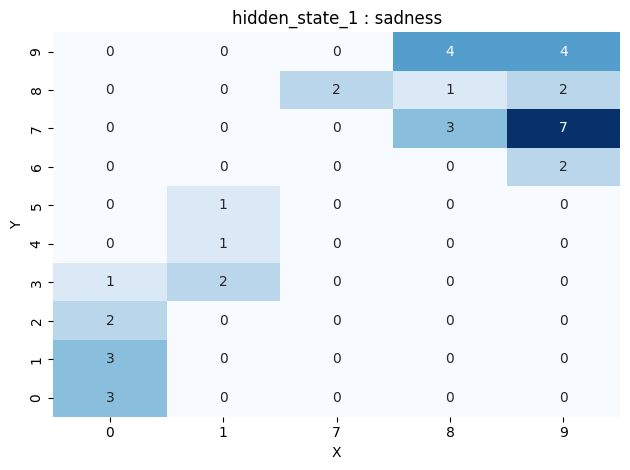

In [11]:
fig = llm_mri.get_layer_image(layer=1, category="sadness")
plt.tight_layout()
plt.show()

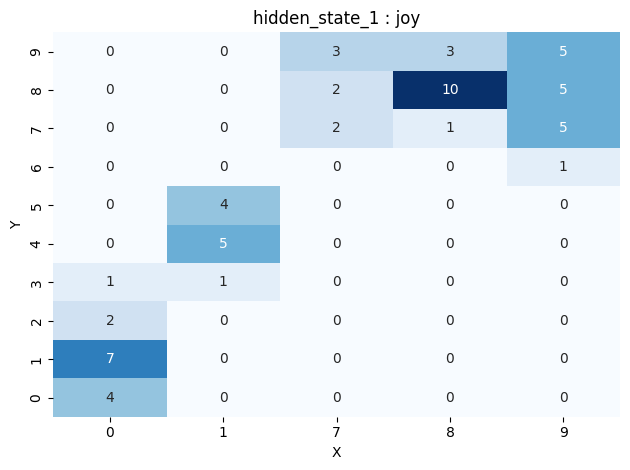

In [12]:
fig = llm_mri.get_layer_image(layer=1, category="joy")
plt.tight_layout()
plt.show()

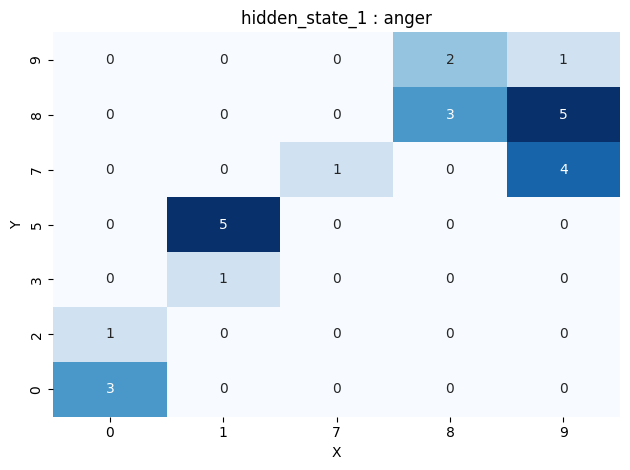

In [13]:
fig = llm_mri.get_layer_image(layer=1, category="anger")
plt.tight_layout()
plt.show()

Here, we can observe the activations in the first hidden layer across the categories of sadness, joy, and anger. It is evident that "sadness" predominantly activated regions in the top right and bottom left of the grid, while "joy" activations were more evenly distributed across these regions. Additionally, for the "anger" label, the activations were also more evenly spread, but the regions (2, 5) and (7, 6) were significantly more activated than others.

From this observation, we can infer that certain regions, such as (9, 5), are more likely to be associated with "joy" documents, since a significant portion of these documents activated these regions, while none of the "anger" and "sadness" documents did.

We also observe that, as the first hidden layers are less specific than the later ones, a considerable portion of the activations between distinct categories overlap. In the following plots, we can visualize how these activations change as we move to deeper layers:

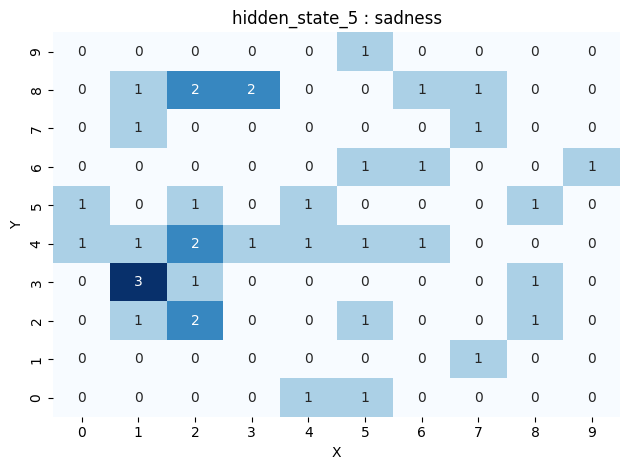

In [14]:
fig = llm_mri.get_layer_image(layer=5, category="sadness")
plt.tight_layout()
plt.show()

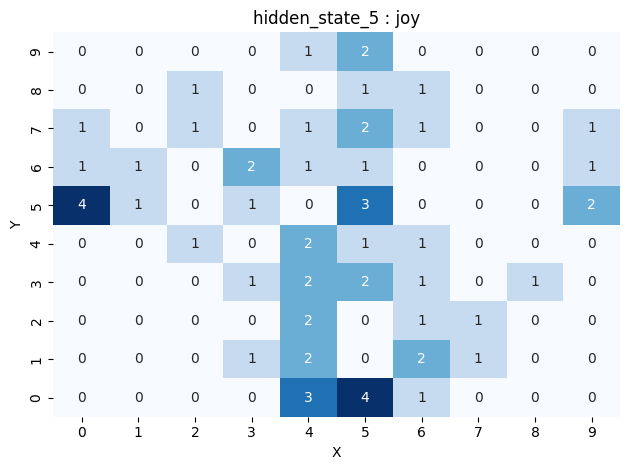

In [15]:
fig = llm_mri.get_layer_image(layer=5, category="joy")
plt.tight_layout()
plt.show()

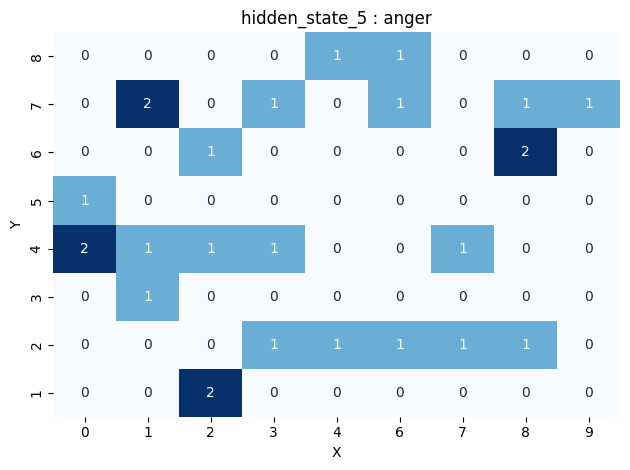

In [16]:
fig = llm_mri.get_layer_image(layer=5, category="anger")
plt.tight_layout()
plt.show()

Analyzing the final hidden layer, we observe that most of the cells with the highest number of activations differ among the categories. For instance, the region with the highest activations for "sadness" documents is (8, 7), a region that is not activated by "joy" or "anger" documents, suggesting a strong association with "sadness."

Similarly, for "joy" activations, regions (0, 5) and (0, 6) show a significant number of activations. These regions are heavily activated by "sadness" and "anger" documents, indicating that their high activation frequency is likely associated with "joy" documents.

## Graph visualization

The _get_graph()_ function enables the user to obtain a Networkx graph representing the neuron activations in the hidden states. Each set of nodes represents activations in a specific hidden layer, while the edges between nodes indicate that documents with the specified label activated both regions.

The _get_graph_image()_ function generates an image of the graph, allowing it to be visualized by the user.

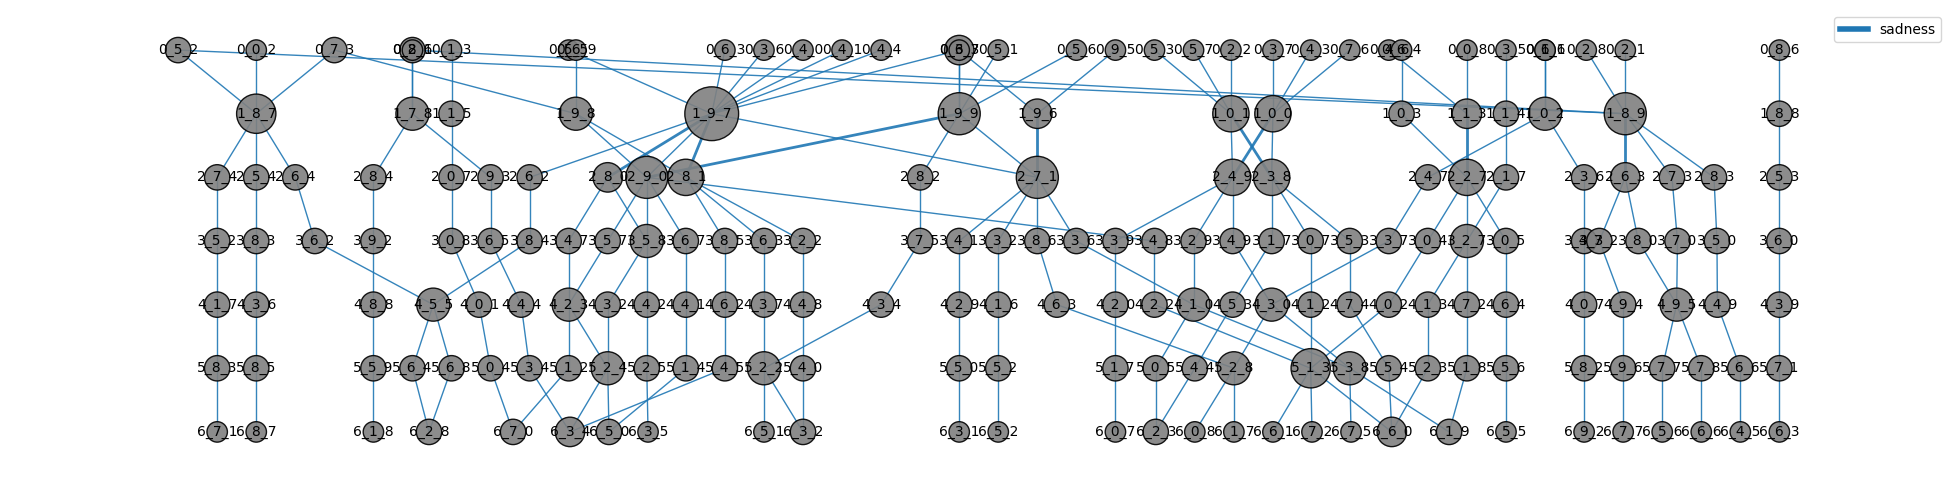

In [17]:
g = llm_mri.get_graph("sadness")

g_img = llm_mri.get_graph_image(g)
plt.box(False)
plt.show()

Here, we can see the graph visualization for the "sadness" category. Each cell represents an activation region, in the format _hiddenstate_x_y_. 

By getting the graph, it is possible to apply complex networks measurements to evaluate more densely connected nodes and regions. With that, we can evaluate the nodes with the highest centralities, identify clusters, and apply other metrics to enhance the graph's understanding.

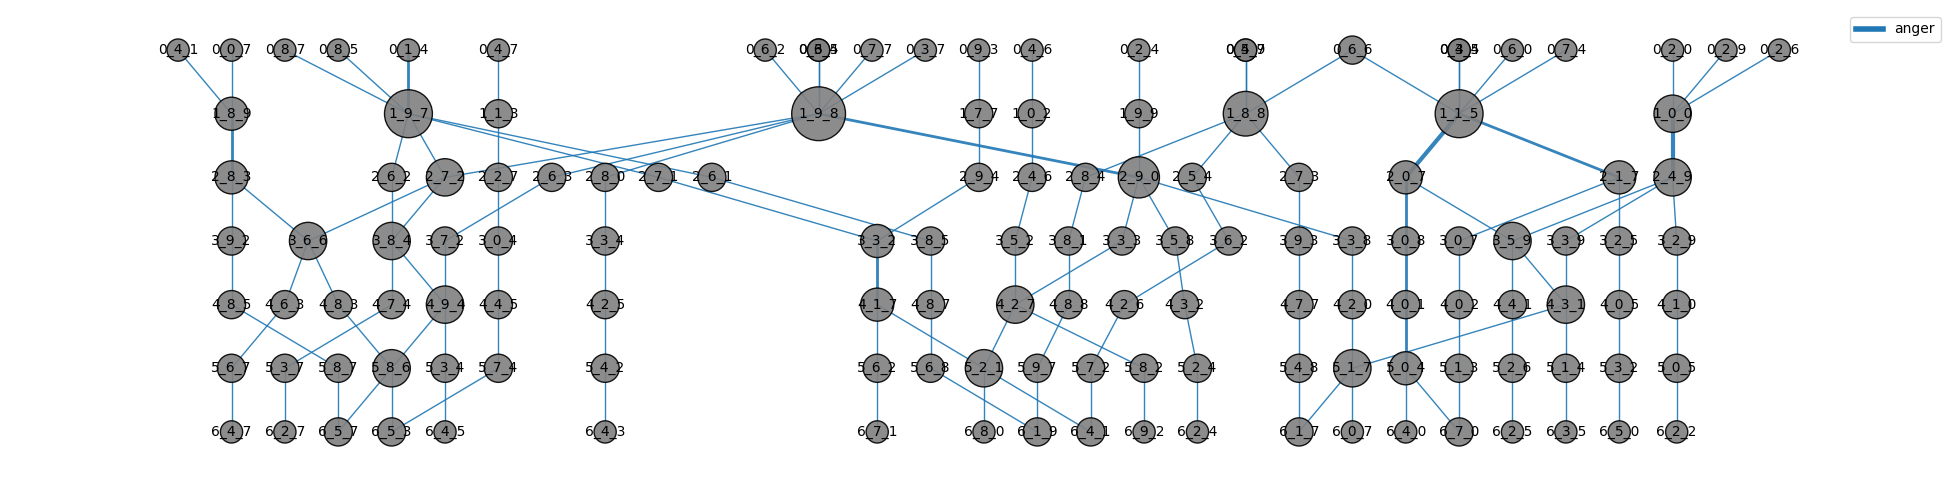

In [18]:
g = llm_mri.get_graph("anger")

g_img = llm_mri.get_graph_image(g)
plt.box(False)
plt.show()

On the image above, it is possible to visualize the graph representation for the "anger" activation regions.

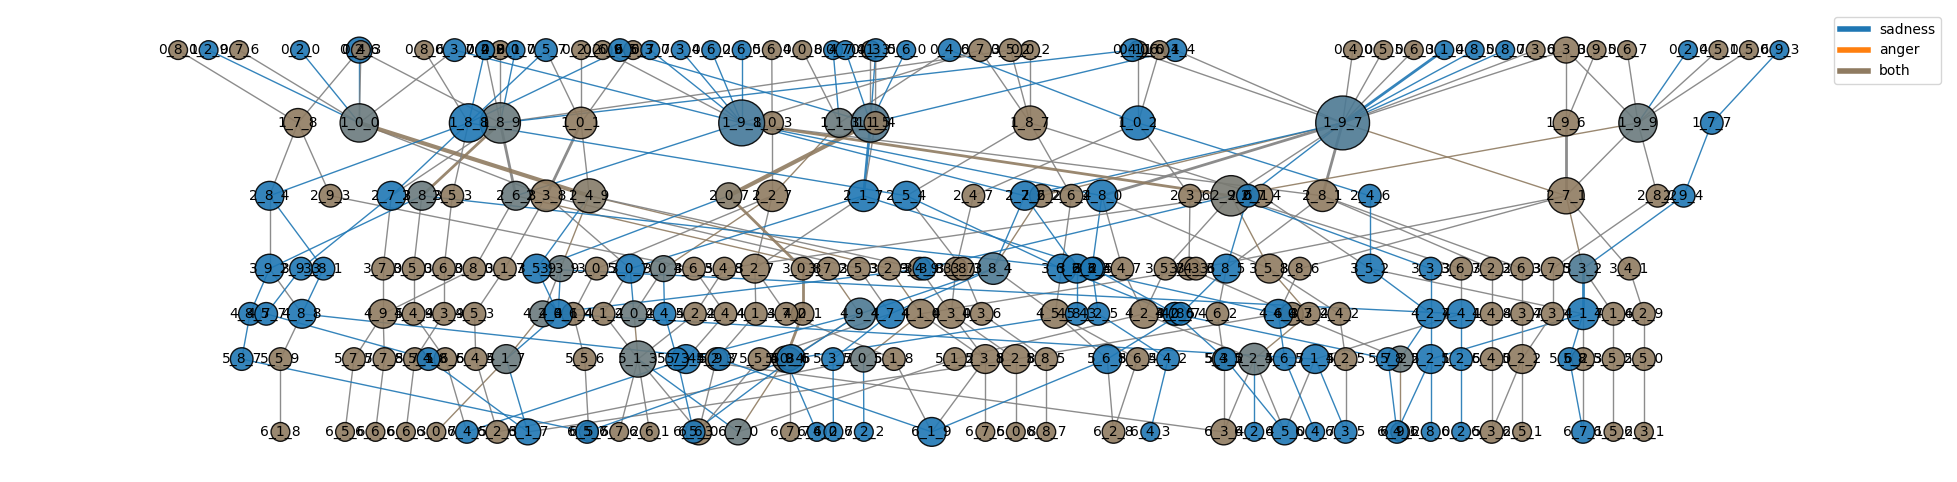

In [19]:
g_composed = llm_mri.get_composed_graph("sadness", "anger")
g_composed_img = llm_mri.get_graph_image(g_composed)

plt.box(False)
plt.show()

Through the _get_composed_graph()_ method, the user is also able to get a composed visualization of two different categories. By setting a category, each edge is colored based on the designed category, so the user is able to see which document label activated each region. On the image above, the blue color refers to the "anger" documents activations, while the green color shows "sadness" activations, and orange represent regions activated by both categories.